In [17]:
using Pkg; Pkg.activate("."); Pkg.instantiate()

 Activating environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`


# 5 GLMの尤度比検定と検定の非対称性

In [18]:
using CSV
using Distributions
using GLM
using Plots
using StatsBase
using Statistics

In [19]:
df = CSV.read(joinpath("..", "data/section3.csv"))

,y,x,f
,Int64,Float64,String
1,6,8.31,C
2,6,9.44,C
3,6,9.5,C
4,12,9.07,C
5,10,10.16,C
6,4,8.32,C
7,9,10.61,C
8,9,10.06,C
9,9,9.93,C


### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法
一定モデル

In [20]:
fit1 = glm(@formula(y ~ 1), df, GLM.Poisson())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Poisson{Float64},LogLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1

Coefficients:
──────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error  z value  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   2.05796   0.0357371  57.5862    <1e-99    1.98792    2.12801
──────────────────────────────────────────────────────────────────────────

xモデル

In [21]:
fit2 = glm(@formula(y ~ x), df, GLM.Poisson())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Poisson{Float64},LogLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
───────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error  z value  Pr(>|z|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  1.29172     0.363686   3.55174    0.0004   0.578909   2.00453
x            0.0756619   0.0356042  2.12509    0.0336   0.005879   0.145445
───────────────────────────────────────────────────────────────────────────

### 残差逸脱度の差

In [22]:
deviance(fit1) - deviance(fit2)

4.513941078851829

### 真のモデルから100個体分のデータを新しく生成

In [23]:
df.y_rnd = rand(Poisson(mean(df.y)), 100)

100-element Array{Int64,1}:
 10
  5
  7
 10
  6
  8
 12
  5
  9
 10
  8
 11
 13
  ⋮
  7
  7
 11
  5
  6
  4
 11
 10
  8
 10
  9
 15

### 一定モデルとxモデルをこの真データに当てはめる

In [24]:
fit1 = glm(@formula(y_rnd ~ 1), df, GLM.Poisson())
fit2 = glm(@formula(y_rnd ~ x), df, GLM.Poisson())
deviance(fit1) - deviance(fit2)

0.19437225171921568

### PB法を実行する関数
データの生成と逸脱度差の評価

In [25]:
function get_dd(df)
    n_samples = size(df, 1)
    y_mean = mean(df.y)
    df.y_rnd = rand(Poisson(y_mean), n_samples)
    fit1 = glm(@formula(y_rnd ~ 1), df, GLM.Poisson())
    fit2 = glm(@formula(y_rnd ~ x), df, GLM.Poisson())
    deviance(fit1) - deviance(fit2)
end

get_dd (generic function with 1 method)

In [26]:
function pb(df, n_bootstrap)
    [get_dd(df) for _ in 1:n_bootstrap]
end

pb (generic function with 1 method)

### 逸脱度の差のサンプルを1000個を作成

In [27]:
dd12 = pb(df, 1000)

1000-element Array{Float64,1}:
 0.20131190752550765
 0.14340189289684702
 1.5596004764753815
 0.14865646554004286
 0.5152015258588989
 0.31700610703182974
 0.009970464674623258
 0.9537188115813393
 0.0015009642323775552
 0.0038192509022962895
 0.037905041277170426
 0.6705732120159666
 0.04878301129444651
 ⋮
 0.0004440006674997221
 0.4445880614095046
 0.07163501558277119
 3.2227813998535737
 0.4475289235558222
 1.832496883247586
 0.34270354684640836
 3.2900400346451306
 0.38223233438138493
 0.9511323318077274
 0.3540388349066035
 0.014956896780262241

In [28]:
describe(dd12)

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           0.928926
Minimum:        0.000001
1st Quartile:   0.079751
Median:         0.411421
3rd Quartile:   1.222284
Maximum:        14.685642
Type:           Float64


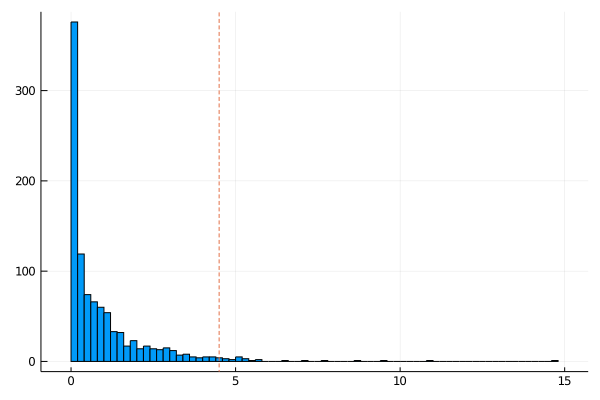

In [29]:
histogram(dd12, bins=100, label="")
plot!([4.5], seriestype=:vline, linestyle=:dash, label="")

合計1000個の$\Delta D_{1,2}$のうちいくつが4.5より右にあるか

In [30]:
sum(dd12 .>= 4.5)

25

$P=0.05$となる逸脱度の差

In [31]:
quantile(dd12, 0.95)

3.558692353422625

### 方法(2) $\chi^2$分布を使った近似計算法

In [32]:
ccdf(Chisq(1), 4.513)

0.03363819191961954

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*